### Example 1: Fitting data using Least Squares (no ready-made software tools)
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________
The purpose of this little exercise is to use a very simple linear fit to a set of datapoints as an example for a linear forward model as well as the inversion of the parameters needed to explain the curve-fit. Once you have done this and understood the math behind it, you will be able to apply the strategy to a wider set of problems!

Just some style definitions at the top (to make it pretty) and import of most important tools

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
import matplotlib.pyplot as plt
import numpy as np
# nicer figures using ggg plot style.
plt.style.use('ggplot')
from IPython.core.display import HTML
def css_styling():
    styles = open("../../python/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

Most of you (I hope so) have probably performed fits of a simple linear equation to a $(\vec{x},\vec{y})$ dataset. In the simplest case, we are interested in linear fit with slope $a_2$ and offset $a_1$: $y = a_1 + a_2\cdot x$.

If we have a set of points $(x,y)$, we can find the optimal coefficients $a_1,a_2$ by minimizing the squared differences between measurement and model, hence least squares. 

To find the solution, we can rephrase the problem using linear algebra:


\begin{equation}
\begin{bmatrix}
 y_1 \\ y_2 \\ \vdots \\ y_{m} 
 \end{bmatrix}
 =
 \begin{pmatrix}
  1 && x_1 \\
  1 && x_2 \\
  \vdots && \vdots \\
  1 && x_m
  \end{pmatrix}
  \times
  \begin{pmatrix}
  a_1 \\ a_2 
  \end{pmatrix}
\end{equation}

In short hand, we can use $Ka=y$. The optimal solution to $a$ is obtianed by minimizing the squared differences between $Ka$ and $y$, i.e. $min||Ka-y||^2$ or minimize $(Ka-x)^T (Ka-x)$, just two different ways of writing it. 

In the ordinary unweighted least squares case, the solution is given by the normal equations (if you want the derivation, check http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression):
$$a = (K^TK)^{-1}K^Ty$$

Note: There are more stable ways to solve the normal equations than the brute force application of the matrix equations but we ignore this for now.


('Offset ', '0.08968492262493666')
('Slope ', '2.9800557463177095')


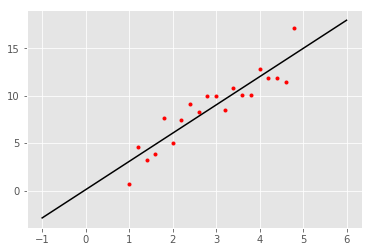

In [4]:
# Import random number generator:
import random
# True values:
a1 = 0
a2 = 3

# Generate a random set of x and y:
x = np.arange(1,5,0.2)
#x += np.random.randn(len(x),)
y = a1+a2*x + np.random.randn(len(x),)*2

m = len(x)
K = np.array([np.ones(m), x]).T
#print(K)
#y = np.array(y).reshape(-1, 1)
plt.plot(x, y, 'r.')

# Solve Normal Equation:
a = np.linalg.inv(K.T.dot(K)).dot(K.T).dot(y)
print ('Offset ', str(a[0]))
print ('Slope ', str(a[1]))

# Reconstruct fit:
xx = np.linspace(-1, 6, 2)
yy = np.array(a[0] + a[1] * xx)
plt.plot(xx, yy, color='k')



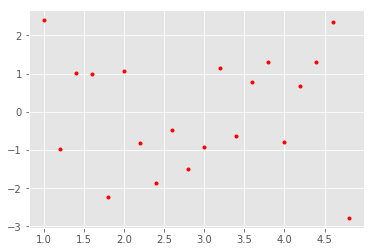

In [6]:
# Plot residuals here:
plt.plot(x, np.dot(K,a)-y, 'r.')

----------------------------

Now let's try to do some same with a better knowledge of the individual measurement errors, which we can include in a measurement error covariance matrix $S_\epsilon$. In the simplest case, $S_\epsilon$ is purely diagonal as measurement errors are usually not correlated with each other (but could). We keep it in Matrix form here to remain general but use a diagonal form.

\begin{equation}
S_{\epsilon} = \left( \begin{array}{ccccc}
\sigma_1^2 & \hfill & \hfill & \hfill & \hfill \\
\hfill & \sigma_2^2 & \hfill & \hfill & \hfill \\
\hfill & \hfill & \ddots &\hfill & \hfill \\
\hfill & \hfill & \hfill & \sigma_{m-1}^2 & \hfill \\
\hfill & \hfill & \hfill & \hfill & \sigma_{m}^2 \\
\end{array} \right)
\end{equation}

with the inverse $S^{-1}_{\epsilon}$ for the diagonal case being:
\begin{equation}
S^{-1}_{\epsilon} = \left( \begin{array}{ccccc}
1/\sigma_1^2 & \hfill & \hfill & \hfill & \hfill \\
\hfill & 1/\sigma_2^2 & \hfill & \hfill & \hfill \\
\hfill & \hfill & \ddots &\hfill & \hfill \\
\hfill & \hfill & \hfill & 1/\sigma_{m-1}^2 & \hfill \\
\hfill & \hfill & \hfill & \hfill & 1/\sigma_{m}^2 \\
\end{array} \right)
\end{equation}

What we need to derive now is the minimum of the weighted differences. In matrix form, the sum of the weighted squared difference can be written as $$(Ka-y)^T S^{-1}_{\epsilon} (Ka-y)$$

Finding the zero slope in the derivate with respect to a yields a slightly modified equation to above:
$$a = (K^T S^{-1}_\epsilon K)^{-1}K^T S^{-1}_\epsilon y$$

Compare this to the optimal solution found in Rodgers at page 25, equation 2.30. What is the main difference? 
_______________



Let us try solving the same problem as above again, this just using the knowledge that the $1\sigma$ error is 2.0. 

In [7]:
# Construct error covariance matrix (do the inverse directly, as it is easy in the diagonal form)
# In principle, we could use a vector here or special forms o diagonal matrices (saves both space and computations)
invSe = np.zeros((m,m))
for i in range(m):
    invSe[i,i] = 1./2.0**2.


And now solve the equation again as before:

('Offset ', '0.08968492262494154')
('Slope ', '2.9800557463177104')


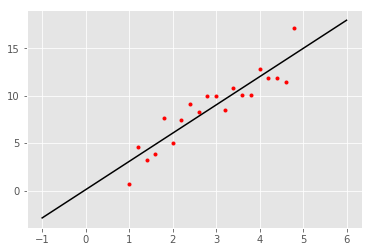

In [8]:
# somewhat overkill here as invSe is diagonal but it works:
aS = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe).dot(y)
print ('Offset ', str(aS[0]))
print ('Slope ', str(aS[1]))

# Reconstruct fit:
xx = np.linspace(-1, 6, 2)
yy = np.array(aS[0] + aS[1] * xx)
plt.plot(x,y,'r.', xx, yy, 'k-')

______
In this example, the 2 solutions are identical as the weighting is the same for each measurement (which can be changed). The biggest advantage in having an idea about the actual uncertainty in the measurements is that we can derive better uncertainties in the derived state vector $a$ (in the future, we will use $x$ for the state vector).
The error covariance of the retrieved state vector is (which we kind of computed already before):

$$\hat{S}=(K^T S^{-1}_\epsilon K)^{-1}$$


____


In [9]:
# Posterior covariance matrix S
S = np.linalg.inv(K.T.dot(invSe).dot(K))

In [10]:
print(S)

[[ 1.46466165 -0.43609023]
 [-0.43609023  0.15037594]]


_______
This might be something you have never really paid attention to as most standard methods never provide the full error covariance matrix (the 2x2 matrix here really is an easy case). 
What does the off-diagonal mean? The errors seems to correlated with the correlation coeffitient $corr(a_1,a_2)=cov(a_1,a_2)/(std(a_1)\cdot std(a_2))$

In [ ]:
print('Correlation between retrieved a1 and a2: ', S[0,1]/(np.sqrt(S[0,0]*np.sqrt(S[1,1]))))
print(r'1sigma error in a1', np.sqrt(S[0,0]))
print(r'1sigma error in a2', np.sqrt(S[1,1]))

_____
Any idea why these variable are correlated with each other (negatively!)? Can you think of a graphical explanation of it?

______________________
How could you re-phrase the problem to make the fits in a_1 and a_2 more independent of each other?

____
Let us run it again using an ensemble to look at the distribution of retrieved properties:


In [ ]:
# Pre-compute Gain Matrix G as we don't need to do that all the time:
Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)

# True values:
a1 = 0
a2 = 3

# Number of samples:
samples = 1000
ar = np.zeros((samples,2))
print(a1,a2)

# Loop through different random fits
for i in range(samples):
    y = a1+a2*x + np.random.randn(len(x),)*2
    a = Gain.dot(y)
    ar[i,0]=a[0]
    ar[i,1]=a[1]


In [ ]:
plt.plot(ar[:,0],ar[:,1],'k.',markersize=2, alpha=0.5)

In [ ]:
# Let's take a look at the covariance computed from the set of retrieved a_1 and a_2
print(np.cov(ar.T))

____
Compare the "data-derived" distribution with the one we predicted using the error-covariance before. Due to the large sample size, they come pretty close. In our case, this was a well behaved example with Gaussian errors but this example also gives you an idea how to derive error statistics using monte carlo simulations (which could draw random errors from a non-Gaussian distribution for instance).